In [38]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# -----------------------------
# Index Sets
# -----------------------------

file_path = "Dataset.xlsx"  

# Read sheet "City"
Index_Details = pd.read_excel(file_path, sheet_name="City")
Distance_Matrix = pd.read_excel(file_path, sheet_name="Distance Matrix")
Chennai = pd.read_excel(file_path, sheet_name="Chennai")
Visit_Duration = pd.read_excel(file_path, sheet_name="Visit Duration")
Avg_Stay = pd.read_excel(file_path, sheet_name="Avg Stay")

# Extract A and T from columns "Index" and "Time"
A = Index_Details["Index"].dropna().astype(int).tolist()
T = Index_Details["Time"].dropna().astype(int).tolist()
# A = [0, 1, 2, 3]       # Set of all places at a station (0 = hub, rest = tourist spots)
# T = [1, 2]             # Set of days

# -----------------------------
# Parameters
# -----------------------------
Q = 10  # Daily hours available per day

# Travel times t^s_ij (hours) between locations i and j
t_time = Chennai.set_index(['from_index', 'to_index'])['Travel Time (hours)'].to_dict()

# give large value for self-loops (to avoid divide by zero in objective)
for i in A:
    t_time[i,i] = 1e6

# Roaming time (tv_j^s) at each location j
tv = Visit_Duration.set_index(['Index'])['time'].to_dict()

# Average travel+stay time q_i (used in MTZ)
q = Avg_Stay.set_index(['Index'])['avg_time'].to_dict()

# -----------------------------
# Model
# -----------------------------
model = gp.Model("Tour_MILP")

# -----------------------------
# Decision Variables
# -----------------------------
# x_ijt : binary, 1 if tourist travels from i to j on day t
x = model.addVars(A, A, T, vtype=GRB.BINARY, name="x")

# x_t : binary, 1 if travel is suggested on day t
x_day = model.addVars(T, vtype=GRB.BINARY, name="xday")

# u_i : MTZ auxiliary variable for subtour elimination
u = model.addVars(A, vtype=GRB.CONTINUOUS, lb=0.0, ub=Q, name="u")

# -----------------------------
# Objective (1)
# -----------------------------
model.setObjective(
    gp.quicksum(x[i,j,t] / t_time[i,j] for i in A for j in A for t in T if i != j),
    GRB.MAXIMIZE
)

# -----------------------------
# Constraints
# -----------------------------
# (2) No self-loops
for i in A:
    model.addConstr(gp.quicksum(x[i,i,t] for t in T) == 0, name=f"no_self_{i}")

# (3) Flow conservation per day
for j in A:
    for t in T:
        model.addConstr(
            gp.quicksum(x[i,j,t] for i in A) == gp.quicksum(x[j,k,t] for k in A),
            name=f"flow_{j}_{t}"
        )

# (4) Visit each non-hub at most once over all days
for j in [a for a in A if a != 0]:
    model.addConstr(
        gp.quicksum(x[i,j,t] for i in A for t in T if i != j) <= 1,
        name=f"visit_once_{j}"
    )

# (5) Start trip from hub
for t in T:
    model.addConstr(
        gp.quicksum(x[0,j,t] for j in A) == x_day[t],
        name=f"start_hub_{t}"
    )

# (6) Daily time budget (travel + roaming)
for t in T:
    model.addConstr(
        gp.quicksum(x[i,j,t] * (t_time[i,j] + tv[j])
                    for i in A if i != 0
                    for j in A if j != 0) <= Q,
        name=f"time_budget_{t}"
    )

# (7) Prioritize earlier days
for idx in range(len(T)-1):
    model.addConstr(x_day[T[idx]] >= x_day[T[idx+1]], name=f"priority_{T[idx]}")

# (8) Binary domains already set by variable types

# (9) MTZ subtour elimination
for i in [a for a in A if a != 0]:
    for j in [a for a in A if a != 0]:
        if i != j:
            for t in T:
                model.addConstr(
                    u[j] - u[i] >= q[i] - Q * (1 - x[i,j,t]),
                    name=f"mtz_{i}_{j}_{t}"
                )

# (10) MTZ lower bound (interpreted as u_i >= q_i)
for i in [a for a in A if a != 0]:
    model.addConstr(u[i] >= q[i], name=f"mtz_lb_{i}")

# (11) MTZ upper bound
for i in A:
    model.addConstr(u[i] <= Q, name=f"mtz_ub_{i}")

# -----------------------------
# Solve
# -----------------------------
model.optimize()

# -----------------------------
# Results
# -----------------------------
# if model.status == GRB.OPTIMAL:
#     print("\nOptimal Objective Value:", model.objVal)
#     print("\nDay decisions:")
#     for t in sorted(T):
#         if x_day[t].X > 0.5:
#             print(f" Day {t}: Travel")
#     print("\nArcs chosen:")
#     for t in sorted(T):
#         for i in A:
#             for j in A:
#                 if x[i, j, t].X > 0.5:
#                     print(f" Day {t}: {i} -> {j}")
#     print("\nMTZ u-values:")
#     for i in A:
#         print(f" u[{i}] = {u[i].X:.2f}")
# -----------------------------
# Results (pretty print like Tabu Search)
# -----------------------------
if model.status == GRB.OPTIMAL:
    print("\n=== MILP RESULT (Gurobi) ===")
    print("Optimal Objective Value:", model.objVal)

    # Build routes per day
    routes = {}
    for t in sorted(T):
        # build adjacency list
        succ = {}
        for i in A:
            for j in A:
                if i != j and x[i,j,t].X > 0.5:
                    succ[i] = j
        # reconstruct path starting at hub if any route exists
        route = [0]
        while route[-1] in succ:
            route.append(succ[route[-1]])
            if route[-1] == 0:  # returned to depot
                break
        routes[t] = route

    # Print per-day details
    for t in sorted(T):
        r = routes.get(t, [0])
        if len(r) <= 1 or (len(r) == 2 and r == [0,0]):
            continue  # no travel that day
        print(f"\nDay {t}:")
        print(" Route:", " -> ".join(map(str, r)))

        # compute time
        total_time = 0.0
        total_cost = 0.0
        for a, b in zip(r[:-1], r[1:]):
            total_time += t_time[a, b]
            if b != 0:
                total_time += tv[b]
            if t_time[a, b] < 1e5:
                total_cost += 1.0 / t_time[a, b]
        print(f" Time: {total_time:.2f} / {Q}")
        print(f" Cost: {total_cost:.6f}")
        print(" Arcs:")
        for a, b in zip(r[:-1], r[1:]):
            print(f"  {a} -> {b}")

    # Print MTZ values too (optional)
    print("\nMTZ u-values:")
    for i in A:
        print(f" u[{i}] = {u[i].X:.2f}")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 169 rows, 173 columns and 937 nonzeros
Model fingerprint: 0xf70feb4c
Variable types: 9 continuous, 164 integer (164 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 42 rows and 42 columns
Presolve time: 0.00s
Presolved: 127 rows, 131 columns, 1488 nonzeros
Variable types: 8 continuous, 123 integer (123 binary)

Root relaxation: objective 8.895322e+01, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

C:\Users\Shubham\AppData\Local\Temp\ipykernel_14792\143996126.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


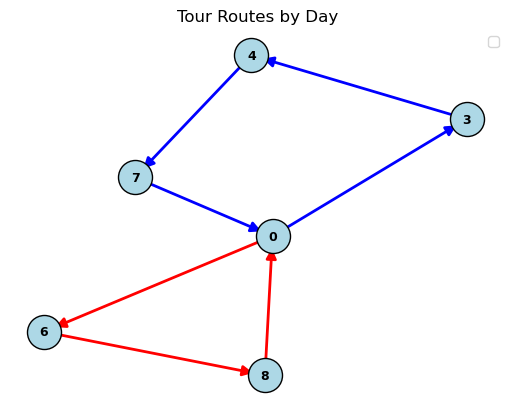

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
# Build arcs_by_day from solution
arcs_by_day = {}
for t in sorted(T):
    arcs_by_day[t] = [(i, j) for i in A for j in A if x[i, j, t].X > 0.5]


# Collect all nodes
A = {i for arcs in arcs_by_day.values() for edge in arcs for i in edge}

# Build a directed graph
G = nx.DiGraph()
G.add_nodes_from(A)
for arcs in arcs_by_day.values():
    G.add_edges_from(arcs)

# Auto layout (no overlaps, nice spacing)
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Colors for days
colors = ["red", "blue", "green", "orange", "purple", "brown"]

# Draw arcs by day
for idx, (t, arcs) in enumerate(sorted(arcs_by_day.items())):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=arcs,
        edge_color=colors[idx % len(colors)],
        arrows=True,
        arrowsize=15,
        width=2,
        label=f"Day {t}"
    )

plt.legend()
plt.title("Tour Routes by Day")
plt.axis("off")
plt.show()


In [39]:
# holmes_parker.py
import pandas as pd
from copy import deepcopy

# -----------------------------
# Load data (same format as your Gurobi code)
# -----------------------------
file_path = "Dataset.xlsx"

Index_Details = pd.read_excel(file_path, sheet_name="City")
Chennai = pd.read_excel(file_path, sheet_name="Chennai")
Visit_Duration = pd.read_excel(file_path, sheet_name="Visit Duration")
Avg_Stay = pd.read_excel(file_path, sheet_name="Avg Stay")

A = Index_Details["Index"].dropna().astype(int).tolist()   # nodes (0 is hub)
T = Index_Details["Time"].dropna().astype(int).tolist()    # days
Q = 10  # daily hours available (same as your model)

# travel times dict keyed by tuple (i,j)
t_time = Chennai.set_index(['from_index', 'to_index'])['Travel Time (hours)'].to_dict()
# avoid divide-by-zero/self-loops: leave sentinel large travel time for i==i
for i in A:
    t_time[(i, i)] = 1e6

# roaming time at arrival j
tv = Visit_Duration.set_index(['Index'])['time'].to_dict()

# list of customers (non-hub nodes)
CUSTOMERS = [a for a in A if a != 0]
DAYS = sorted(T)

# -----------------------------
# Helpers: time, cost, feasibility
# -----------------------------
def route_time(route):
    """Compute total time (travel + roaming arrivals) for a route list [0,a,b,...,0]."""
    total = 0.0
    for i, j in zip(route[:-1], route[1:]):
        total += t_time[(i, j)]
        if j != 0:
            total += tv.get(j, 0.0)
    return total

def route_obj(route):
    """Objective contribution of route: sum(1/t_ij) over arcs (skip sentinel arcs)."""
    val = 0.0
    for i, j in zip(route[:-1], route[1:]):
        tij = t_time[(i, j)]
        if tij < 1e5:
            val += 1.0 / tij
    return val

def can_insert(route, pos, node, Q):
    """Check if inserting 'node' at position pos (0..len(route)-1 so that it's placed before route[pos]) respects time budget."""
    new_route = route[:pos] + [node] + route[pos:]
    return route_time(new_route) <= Q + 1e-9

# -----------------------------
# Holmes & Parker insertion heuristic
# -----------------------------
def holmes_parker_construct(seed_rule="earliest_index"):
    """
    Build routes for all days using Holmes & Parker style insertion.
    seed_rule: currently only 'earliest_index' implemented (deterministic).
    Returns: dict day -> route (list starting and ending with 0)
    """
    # Unassigned customers
    unassigned = set(CUSTOMERS)

    # Routes per day start as [0,0] (empty)
    routes = {d: [0, 0] for d in DAYS}

    # Visit each day in order (priority earlier days)
    for d in DAYS:
        # If no unassigned customers remain, stop early
        if not unassigned:
            break

        # Select seed customer for this day's route
        if seed_rule == "earliest_index":
            seed = min(unassigned)  # deterministic
        else:
            seed = min(unassigned)

        # Start route [0, seed, 0] only if feasible
        if can_insert([0,0], 1, seed, Q):
            routes[d] = [0, seed, 0]
            unassigned.remove(seed)
        else:
            # if seed infeasible for this day (rare), skip day (no route)
            continue

        # Now iteratively insert best feasible customer until no insertion possible
        improved = True
        while improved and unassigned:
            improved = False
            best_gain = -1e18
            best_insertion = None  # (pos, node, new_route, gain)

            curr_route = routes[d]
            curr_obj = route_obj(curr_route)

            # Try each unassigned customer and every insertion position
            for node in list(unassigned):
                for pos in range(1, len(curr_route)):  # insert before curr_route[pos]
                    # feasibility test: time budget
                    if not can_insert(curr_route, pos, node, Q):
                        continue
                    new_route = curr_route[:pos] + [node] + curr_route[pos:]
                    new_obj = route_obj(new_route)
                    gain = new_obj - curr_obj
                    # Holmes & Parker normally uses travel/time increase; here we align with your objective:
                    # choose insertion which **maximizes objective gain** (1/t contributions)
                    if gain > best_gain + 1e-12:
                        best_gain = gain
                        best_insertion = (pos, node, new_route, gain)

            # If a positive-gain insertion exists, accept it (ties broken by larger gain)
            if best_insertion is not None and best_insertion[3] > -1e-12:
                pos, node, new_route, gain = best_insertion
                routes[d] = new_route
                unassigned.remove(node)
                improved = True
            else:
                # no non-worsening insertion found; we still might accept a slight negative gain
                # if it allows visiting more nodes — but standard H&P chooses feasible best-insertion (could be negative).
                # We'll allow the best feasible insertion even if it reduces objective, but only if it increases count of visited nodes.
                # Find best feasible insertion regardless of sign
                best_any = None
                best_any_gain = -1e18
                for node in list(unassigned):
                    for pos in range(1, len(curr_route)):
                        if not can_insert(curr_route, pos, node, Q):
                            continue
                        new_route = curr_route[:pos] + [node] + curr_route[pos:]
                        new_obj = route_obj(new_route)
                        gain = new_obj - curr_obj
                        if gain > best_any_gain:
                            best_any_gain = gain
                            best_any = (pos, node, new_route, gain)
                if best_any is not None:
                    # accept it (this choice aims to increase visited cities count at some objective cost)
                    pos, node, new_route, gain = best_any
                    routes[d] = new_route
                    unassigned.remove(node)
                    improved = True
                else:
                    # no feasible insertions left for this day
                    improved = False

    # Done building routes for all days. Return result (some customers might remain unassigned)
    return routes, unassigned

# -----------------------------
# Pretty print results (same format as Tabu output)
# -----------------------------
def print_routes(routes, Q):
    print("\n=== Holmes & Parker Constructive Heuristic Result ===")
    total_obj = 0.0
    used_any = False
    for d in sorted(routes.keys()):
        r = routes[d]
        # normalize: if last node not 0, append 0 (should not happen in our construction)
        if r[-1] != 0:
            r = r + [0]
        if len(r) <= 2:
            continue
        used_any = True
        obj = route_obj(r)
        t = route_time(r)
        total_obj += obj
        print(f"\nDay {d}:")
        print(" Route:", " -> ".join(map(str, r)))
        print(f" Time: {t:.2f} / {Q}")
        print(f" Cost (sum 1/t_ij): {obj:.6f}")
        print(" Arcs:")
        for a, b in zip(r[:-1], r[1:]):
            print(f"  {a} -> {b}  (t_ij={t_time[(a,b)]:.3f})")
    if not used_any:
        print("No routes constructed (all routes empty).")
    else:
        print(f"\nTotal objective (all days): {total_obj:.6f}")

# -----------------------------
# Example run
# -----------------------------
if __name__ == "__main__":
    routes, unassigned = holmes_parker_construct()
    print_routes(routes, Q)
    if unassigned:
        print("\nUnassigned customers (couldn't fit into any day's route):", sorted(unassigned))



=== Holmes & Parker Constructive Heuristic Result ===

Day 1:
 Route: 0 -> 6 -> 1 -> 4 -> 8 -> 0
 Time: 8.97 / 10
 Cost (sum 1/t_ij): 39.585100
 Arcs:
  0 -> 6  (t_ij=0.077)
  6 -> 1  (t_ij=0.408)
  1 -> 4  (t_ij=0.298)
  4 -> 8  (t_ij=0.099)
  8 -> 0  (t_ij=0.093)

Day 2:
 Route: 0 -> 7 -> 3 -> 2 -> 0
 Time: 8.80 / 10
 Cost (sum 1/t_ij): 19.877552
 Arcs:
  0 -> 7  (t_ij=0.121)
  7 -> 3  (t_ij=0.100)
  3 -> 2  (t_ij=1.196)
  2 -> 0  (t_ij=1.388)

Total objective (all days): 59.462652

Unassigned customers (couldn't fit into any day's route): [5]


In [41]:
# nearest_neighbor.py
import pandas as pd

file_path = "Dataset.xlsx"

# Load data (same as your MILP + Holmes & Parker)
Index_Details = pd.read_excel(file_path, sheet_name="City")
Chennai = pd.read_excel(file_path, sheet_name="Chennai")
Visit_Duration = pd.read_excel(file_path, sheet_name="Visit Duration")

A = Index_Details["Index"].dropna().astype(int).tolist()   # nodes (0 = hub)
T = Index_Details["Time"].dropna().astype(int).tolist()    # days
Q = 10  # daily time budget (hours)

t_time = Chennai.set_index(['from_index', 'to_index'])['Travel Time (hours)'].to_dict()
for i in A:
    t_time[(i, i)] = 1e6  # large self-loop

tv = Visit_Duration.set_index(['Index'])['time'].to_dict()

CUSTOMERS = [a for a in A if a != 0]
DAYS = sorted(T)

def route_time(route):
    total = 0.0
    for i, j in zip(route[:-1], route[1:]):
        total += t_time[(i, j)]
        if j != 0:
            total += tv.get(j, 0.0)
    return total

def route_obj(route):
    val = 0.0
    for i, j in zip(route[:-1], route[1:]):
        tij = t_time[(i, j)]
        if tij < 1e5:
            val += 1.0 / tij
    return val

def nearest_neighbor_construct():
    """Greedy nearest neighbor route construction per day."""
    unassigned = set(CUSTOMERS)
    routes = {d: [0, 0] for d in DAYS}

    for d in DAYS:
        if not unassigned:
            break

        route = [0]
        current = 0
        total_time = 0.0

        while True:
            # find nearest feasible neighbor
            best_next = None
            best_dist = float("inf")

            for j in unassigned:
                travel = t_time[(current, j)]
                stay = tv.get(j, 0.0)
                # time if we visit j and return to hub
                projected_time = total_time + travel + stay + t_time[(j, 0)]
                if projected_time <= Q and travel < best_dist:
                    best_dist = travel
                    best_next = j

            if best_next is None:
                break  # no more feasible customers

            # go to best_next
            route.append(best_next)
            total_time += t_time[(current, best_next)] + tv.get(best_next, 0.0)
            current = best_next
            unassigned.remove(best_next)

        # return to hub
        route.append(0)
        routes[d] = route

    return routes, unassigned

def print_routes(routes, Q):
    print("\n=== Nearest Neighbor Heuristic Result ===")
    total_obj = 0.0
    for d in sorted(routes.keys()):
        r = routes[d]
        if len(r) <= 2:
            continue
        obj = route_obj(r)
        t = route_time(r)
        total_obj += obj
        print(f"\nDay {d}:")
        print(" Route:", " -> ".join(map(str, r)))
        print(f" Time: {t:.2f} / {Q}")
        print(f" Cost (sum 1/t_ij): {obj:.6f}")
        print(" Arcs:")
        for a, b in zip(r[:-1], r[1:]):
            print(f"  {a} -> {b}  (t_ij={t_time[(a,b)]:.3f})")
    print(f"\nTotal objective (all days): {total_obj:.6f}")

if __name__ == "__main__":
    routes, unassigned = nearest_neighbor_construct()
    print_routes(routes, Q)
    if unassigned:
        print("\nUnassigned customers:", sorted(unassigned))



=== Nearest Neighbor Heuristic Result ===

Day 1:
 Route: 0 -> 6 -> 8 -> 4 -> 7 -> 0
 Time: 7.46 / 10
 Cost (sum 1/t_ij): 57.820188
 Arcs:
  0 -> 6  (t_ij=0.077)
  6 -> 8  (t_ij=0.109)
  8 -> 4  (t_ij=0.099)
  4 -> 7  (t_ij=0.058)
  7 -> 0  (t_ij=0.121)

Day 2:
 Route: 0 -> 3 -> 1 -> 0
 Time: 6.30 / 10
 Cost (sum 1/t_ij): 12.066536
 Arcs:
  0 -> 3  (t_ij=0.186)
  3 -> 1  (t_ij=0.259)
  1 -> 0  (t_ij=0.352)

Total objective (all days): 69.886724

Unassigned customers: [2, 5]


C:\Users\Shubham\AppData\Local\Temp\ipykernel_14792\2776142258.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


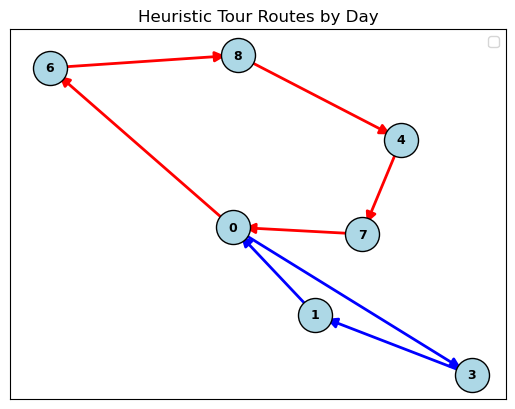

In [47]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_routes(routes):
    """
    Draw routes returned by heuristics like Nearest Neighbor.
    routes: dict of {day: [0, i1, i2, ..., 0]}
    """
    # Build arcs_by_day from route lists
    arcs_by_day = {}
    for d, r in routes.items():
        if len(r) > 1:
            arcs_by_day[d] = [(r[k], r[k+1]) for k in range(len(r)-1)]

    # Collect all nodes
    nodes = {i for arcs in arcs_by_day.values() for edge in arcs for i in edge}

    # Build a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for arcs in arcs_by_day.values():
        G.add_edges_from(arcs)

    # Auto layout
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    # Colors for days
    colors = ["red", "blue", "green", "orange", "purple", "brown"]

    # Draw arcs by day
    for idx, (d, arcs) in enumerate(sorted(arcs_by_day.items())):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=arcs,
            edge_color=colors[idx % len(colors)],
            arrows=True,
            arrowsize=15,
            width=2,
            label=f"Day {d}"
        )

    plt.legend()
    plt.title("Heuristic Tour Routes by Day")

plot_routes(routes)